<a href="https://colab.research.google.com/github/duonghieu7104/Trend-Analysis-Aviation-Industry-US/blob/main/Milestone/Milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/duonghieu7104/Trend-Analysis-Aviation-Industry-US/blob/main/notebook/Market_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean, stddev, sum
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

In [ ]:
 spark = SparkSession.builder \
    .appName("FlightRouteClassification") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()


In [ ]:
import kagglehub
path = kagglehub.dataset_download("bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: C:\Users\PC\.cache\kagglehub\datasets\bhavikjikadara\us-airline-flight-routes-and-fares-1993-2024\versions\1


In [ ]:
df = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .option("quote", '"')           # r·∫•t quan tr·ªçng: nh·∫≠n di·ªán text trong ngo·∫∑c k√©p
    .option("escape", '"')          # escape k√Ω t·ª± "
    .option("multiLine", "true")    # x·ª≠ l√Ω text c√≥ xu·ªëng d√≤ng
    .option("mode", "PERMISSIVE")   # kh√¥ng drop d√≤ng l·ªói
    .option("nullValue", "")
    .option("nanValue", "NaN")
    .option("emptyValue", "")
    .csv(f"{path}/*.csv")
)

In [ ]:
df.printSchema()
print(f"\nS·ªë d√≤ng: {df.count()}")
print(f"S·ªë c·ªôt: {len(df.columns)}")

root
 |-- tbl: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)


S·ªë d√≤ng: 245955
S·ªë c·ªôt: 23


In [ ]:
df.show(5)


+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|    tbl|Year|quarter|citymarketid_1|citymarketid_2|               city1|               city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|  fare|carrier_lg|large_ms|fare_lg|carrier_low| lf_ms|fare_low|Geocoded_City1|Geocoded_City2|             tbl1apk|
+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|Table1a|2021|      3|         30135|         33195|Allentown/Bethleh...|Tampa, FL (Metrop...|      10135|      14112|      ABE|      PIE|    970|       180| 81.43|        G4|     1.0|

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|tbl|Year|quarter|citymarketid_1|citymarketid_2|city1|city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|fare|carrier_lg|large_ms|fare_lg|carrier_low|lf_ms|fare_low|Geocoded_City1|Geocoded_City2|tbl1apk|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|  0|   0|      0|             0|             0|    0|    0|          0|          0|        0|        0|      0|         0|   0|      1540|    1540|   1540|       1612| 1612|    1612|         39206|         39206|      0|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+

In [ ]:
df.select('passengers', 'fare', 'large_ms', 'nsmiles', 'lf_ms').describe().show()

+-------+------------------+-----------------+------------------+-----------------+-------------------+
|summary|        passengers|             fare|          large_ms|          nsmiles|              lf_ms|
+-------+------------------+-----------------+------------------+-----------------+-------------------+
|  count|            245955|           245955|            244415|           245955|             244343|
|   mean| 299.4767945355858|218.9795867943276|0.6652516330831235|1189.812319326706|0.45043751243130975|
| stddev|511.38948561649295|82.37248581123856|0.2246346557290856|703.1434716080329| 0.3326690289129114|
|    min|                 0|             50.0|            0.0038|              109|               0.01|
|    max|              8301|           3377.0|               1.0|             2724|                1.0|
+-------+------------------+-----------------+------------------+-----------------+-------------------+



In [ ]:
df_clean = df.filter(col('large_ms').isNotNull())
print(f"\nK√≠ch th∆∞·ªõc d·ªØ li·ªáu sau khi lo·∫°i b·ªè d√≤ng l·ªói: {df_clean.count()} rows, {len(df_clean.columns)} columns")


K√≠ch th∆∞·ªõc d·ªØ li·ªáu sau khi lo·∫°i b·ªè d√≤ng l·ªói: 244415 rows, 23 columns


In [ ]:
df_clean = df_clean.filter((col('large_ms') >= 0) & (col('large_ms') <= 1))
print(f"S·ªë d√≤ng sau khi l√†m s·∫°ch: {df_clean.count()}")

S·ªë d√≤ng sau khi l√†m s·∫°ch: 244415


In [ ]:
df_clean = df_clean.filter(
    (col('passengers') > 0) &
    (col('fare') > 0) &
    (col('nsmiles') > 0)
)

In [ ]:
df_clean = df_clean.dropna(subset=['carrier_low'])


In [ ]:

df_clean.select([
    sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in df_clean.columns
]).show()

+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+-----------+--------------+--------------------+--------------------+-------------+
|tbl_nulls|Year_nulls|quarter_nulls|citymarketid_1_nulls|citymarketid_2_nulls|city1_nulls|city2_nulls|airportid_1_nulls|airportid_2_nulls|airport_1_nulls|airport_2_nulls|nsmiles_nulls|passengers_nulls|fare_nulls|carrier_lg_nulls|large_ms_nulls|fare_lg_nulls|carrier_low_nulls|lf_ms_nulls|fare_low_nulls|Geocoded_City1_nulls|Geocoded_City2_nulls|tbl1apk_nulls|
+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+----

In [ ]:
print(f"S·ªë d√≤ng c√≤n l·∫°i: {df_clean.count()}")


S·ªë d√≤ng c√≤n l·∫°i: 237985


In [ ]:
df_features = df_clean.withColumn(
    'revenue', col('passengers') * col('fare')
).withColumn(
    'fare_per_mile', col('fare') / col('nsmiles')
).withColumn(
    'fare_difference', col('fare') - col('fare_low')
).withColumn(
    'is_largest_cheapest',
    when(col('carrier_lg') == col('carrier_low'), 1).otherwise(0)
)

In [ ]:
numeric_features = [
    'passengers', 'fare', 'nsmiles', 'lf_ms',
    'fare_low', 'revenue', 'fare_per_mile', 'fare_difference',
    'Year', 'quarter'
]

In [ ]:
categorical_features = ['carrier_lg', 'carrier_low']

In [ ]:
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
    for col in categorical_features
]

In [ ]:
df_features.printSchema()

root
 |-- tbl: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)
 |-- revenue: double (nullable = true)
 |-- fare_per_m

# **1. X√¢y d·ª±ng m√¥ h√¨nh d·ª± ƒëo√°n gi√° v√© v√† l∆∞·ª£ng h√†nh kh√°ch cho t·ª´ng chuy·∫øn bay**

## 1.1 EDA - Ph√¢n t√≠ch ·∫£nh h∆∞·ªõng c·ªßa kho·∫£ng c√°ch ƒë·∫øn gi√° v√©

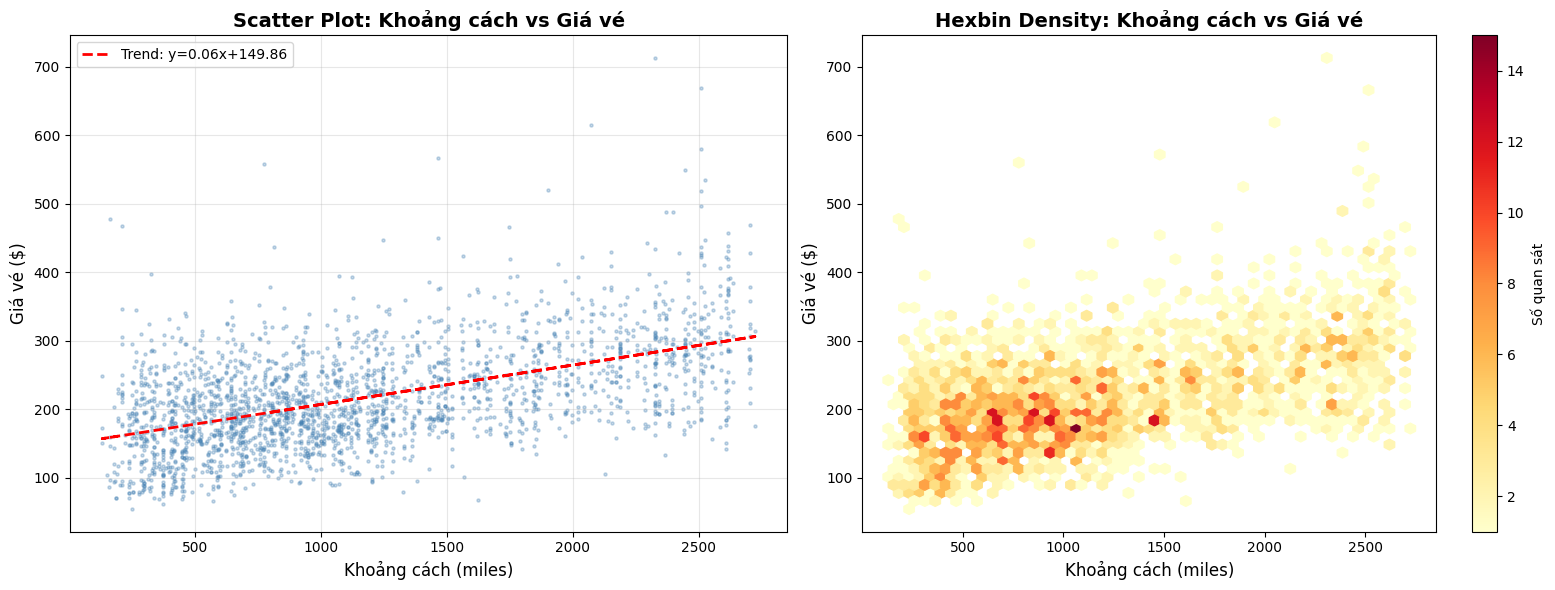


H·ªá s·ªë t∆∞∆°ng quan Pearson: 0.5122


In [ ]:
# M·ª•c ƒë√≠ch: Tr·ª±c quan h√≥a m·ªëi quan h·ªá gi·ªØa kho·∫£ng c√°ch v√† gi√° v√©

# L·∫•y m·∫´u d·ªØ li·ªáu
scatter_sample = df.select('nsmiles', 'fare').sample(False, sample_size, seed=42).toPandas()

# T·∫°o figure v·ªõi 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot th√¥ng th∆∞·ªùng
axes[0].scatter(scatter_sample['nsmiles'], scatter_sample['fare'],
                alpha=0.3, s=5, color='steelblue')
axes[0].set_xlabel('Kho·∫£ng c√°ch (miles)', fontsize=12)
axes[0].set_ylabel('Gi√° v√© ($)', fontsize=12)
axes[0].set_title('Scatter Plot: Kho·∫£ng c√°ch vs Gi√° v√©', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Th√™m ƒë∆∞·ªùng xu h∆∞·ªõng (trend line)
z = np.polyfit(scatter_sample['nsmiles'], scatter_sample['fare'], 1)
p = np.poly1d(z)
axes[0].plot(scatter_sample['nsmiles'], p(scatter_sample['nsmiles']),
             "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend(fontsize=10)

# 2. Hexbin plot (t·ªët h∆°n cho nhi·ªÅu ƒëi·ªÉm)
hb = axes[1].hexbin(scatter_sample['nsmiles'], scatter_sample['fare'],
                     gridsize=50, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Kho·∫£ng c√°ch (miles)', fontsize=12)
axes[1].set_ylabel('Gi√° v√© ($)', fontsize=12)
axes[1].set_title('Hexbin Density: Kho·∫£ng c√°ch vs Gi√° v√©', fontsize=14, fontweight='bold')
cb = plt.colorbar(hb, ax=axes[1])
cb.set_label('S·ªë quan s√°t', fontsize=10)

plt.tight_layout()
plt.show()

# In t∆∞∆°ng quan
corr_distance_fare = df.stat.corr("nsmiles", "fare")
print(f"\nH·ªá s·ªë t∆∞∆°ng quan Pearson: {corr_distance_fare:.4f}")

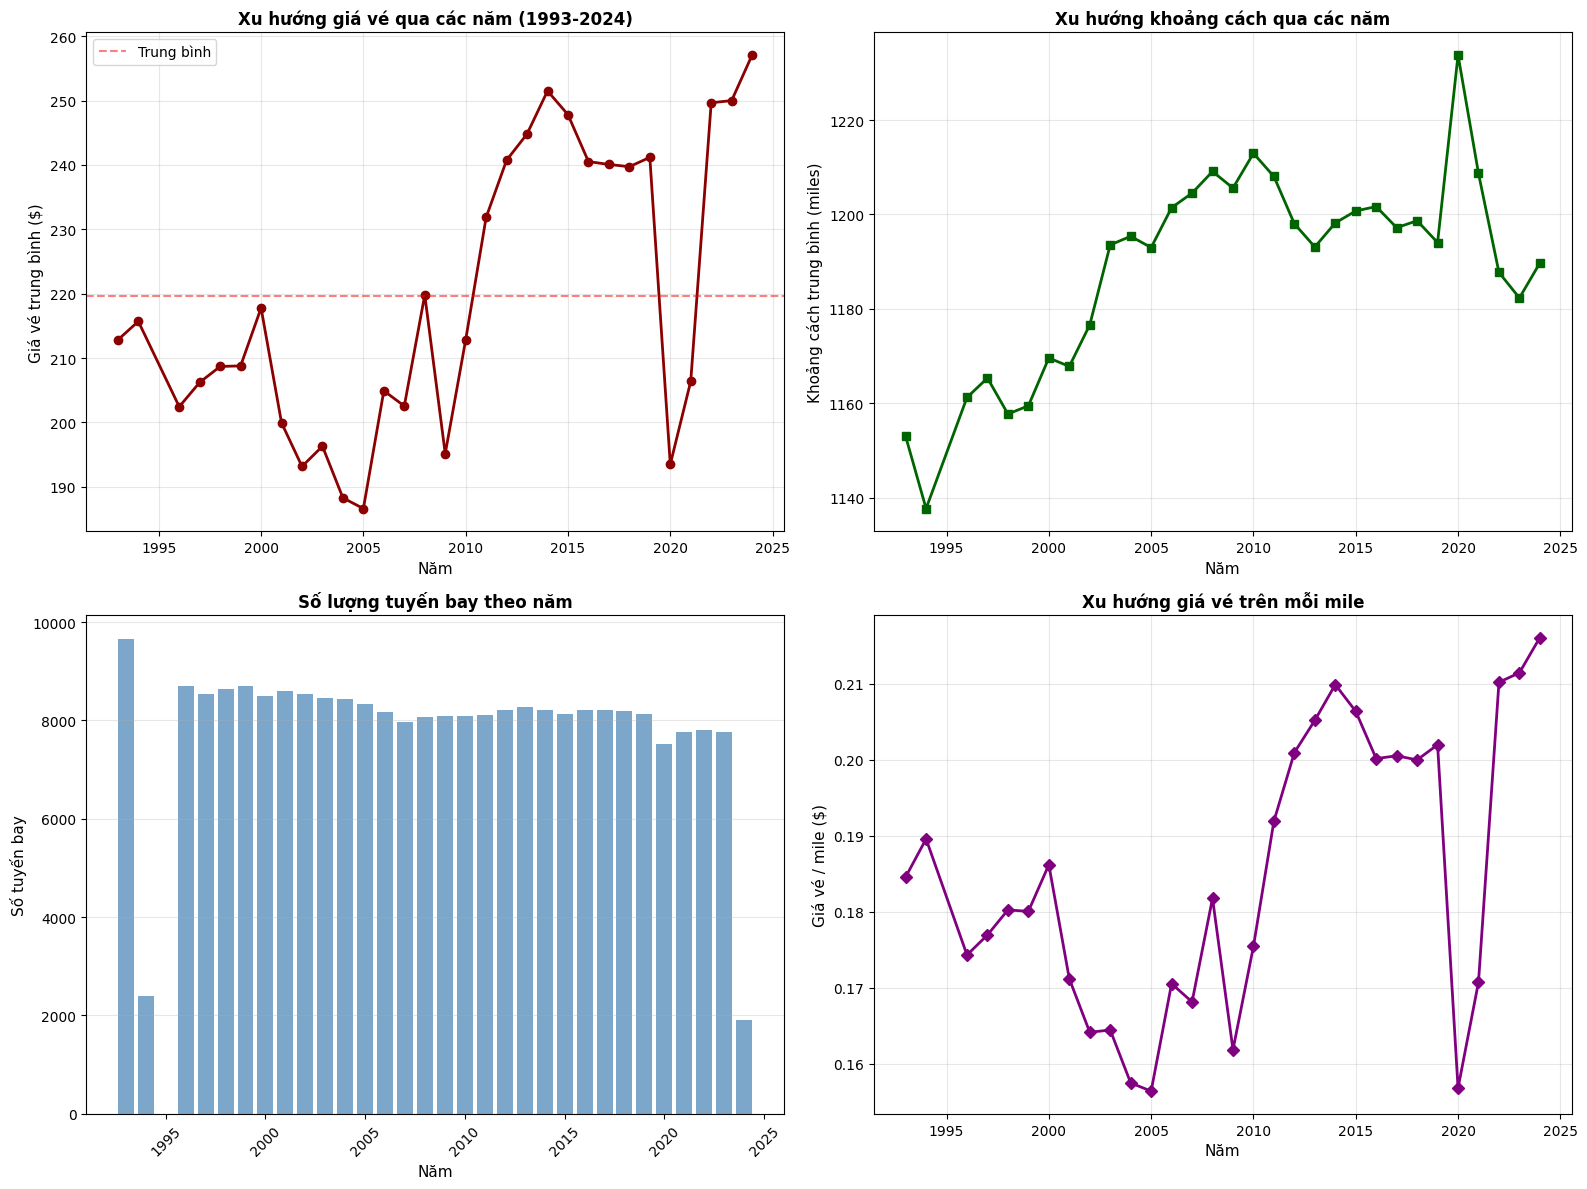

In [ ]:
# T√≠nh trung b√¨nh theo nƒÉm
yearly_stats = df.groupBy('Year').agg(
    avg('fare').alias('gia_trung_binh'),
    avg('nsmiles').alias('khoang_cach_trung_binh'),
    avg('passengers').alias('hanh_khach_trung_binh'),
    count('*').alias('so_chuyen')
).orderBy('Year').toPandas()

# T·∫°o figure v·ªõi 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gi√° v√© trung b√¨nh theo nƒÉm
axes[0, 0].plot(yearly_stats['Year'], yearly_stats['gia_trung_binh'],
                marker='o', linewidth=2, markersize=6, color='darkred')
axes[0, 0].set_xlabel('NƒÉm', fontsize=11)
axes[0, 0].set_ylabel('Gi√° v√© trung b√¨nh ($)', fontsize=11)
axes[0, 0].set_title('Xu h∆∞·ªõng gi√° v√© qua c√°c nƒÉm (1993-2024)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=yearly_stats['gia_trung_binh'].mean(),
                    color='r', linestyle='--', alpha=0.5, label='Trung b√¨nh')
axes[0, 0].legend()

# 2. Kho·∫£ng c√°ch trung b√¨nh theo nƒÉm
axes[0, 1].plot(yearly_stats['Year'], yearly_stats['khoang_cach_trung_binh'],
                marker='s', linewidth=2, markersize=6, color='darkgreen')
axes[0, 1].set_xlabel('NƒÉm', fontsize=11)
axes[0, 1].set_ylabel('Kho·∫£ng c√°ch trung b√¨nh (miles)', fontsize=11)
axes[0, 1].set_title('Xu h∆∞·ªõng kho·∫£ng c√°ch qua c√°c nƒÉm', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. S·ªë chuy·∫øn bay theo nƒÉm
axes[1, 0].bar(yearly_stats['Year'], yearly_stats['so_chuyen'],
               color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('NƒÉm', fontsize=11)
axes[1, 0].set_ylabel('S·ªë tuy·∫øn bay', fontsize=11)
axes[1, 0].set_title('S·ªë l∆∞·ª£ng tuy·∫øn bay theo nƒÉm', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Gi√° v√© tr√™n m·ªói mile
yearly_stats['gia_per_mile'] = yearly_stats['gia_trung_binh'] / yearly_stats['khoang_cach_trung_binh']
axes[1, 1].plot(yearly_stats['Year'], yearly_stats['gia_per_mile'],
                marker='D', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_xlabel('NƒÉm', fontsize=11)
axes[1, 1].set_ylabel('Gi√° v√© / mile ($)', fontsize=11)
axes[1, 1].set_title('Xu h∆∞·ªõng gi√° v√© tr√™n m·ªói mile', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("X·ª¨ L√ù L·ªñI D·ªÆ LI·ªÜU - LO·∫†I B·ªé V√â KH√îNG C√ì H√ÄNH KH√ÅCH")

# ƒê·∫øm s·ªë v√© c√≥ passengers = 0
zero_pax = df.filter(col('passengers') == 0).count()
total = df.count()

print(f"\n1. PH√ÇN T√çCH:")
print(f"  V√© c√≥ passengers = 0: {zero_pax:,} ({zero_pax/total*100:.2f}%)")

# Xem ph√¢n ph·ªëi gi√° c·ªßa nh·ªØng v√© n√†y
print("\n2. PH√ÇN PH·ªêI GI√Å C·ª¶A V√â C√ì PASSENGERS = 0:")
df.filter(col('passengers') == 0).select('fare').describe().show()

print("\n3. QUY·∫æT ƒê·ªäNH:")
print("  ‚úÖ LO·∫†I B·ªé t·∫•t c·∫£ v√© c√≥ passengers = 0")
print("  L√ù DO:")
print("    ‚Ä¢ Kh√¥ng logic: v√© kh√¥ng th·ªÉ c√≥ gi√° n·∫øu kh√¥ng c√≥ h√†nh kh√°ch")
print("    ‚Ä¢ Ch·ª©a c√°c outliers gi√° v√© cao b·∫•t th∆∞·ªùng")
print("    ‚Ä¢ D·ªØ li·ªáu kh√¥ng ƒë√°ng tin c·∫≠y")

# Lo·∫°i b·ªè
df = df.filter(col('passengers') > 0)

print(f"\n4. K·∫æT QU·∫¢:")
print(f"  ƒê√£ lo·∫°i b·ªè: {zero_pax:,} d√≤ng")
print(f"  C√≤n l·∫°i: {df.count():,} d√≤ng")

# Ki·ªÉm tra l·∫°i gi√° v√© cao nh·∫•t
max_fare = df.agg(max('fare')).collect()[0][0]
print(f"  Gi√° v√© cao nh·∫•t sau x·ª≠ l√Ω: ${max_fare:,.2f}")

X·ª¨ L√ù L·ªñI D·ªÆ LI·ªÜU - LO·∫†I B·ªé V√â KH√îNG C√ì H√ÄNH KH√ÅCH

1. PH√ÇN T√çCH:
  V√© c√≥ passengers = 0: 0 (0.00%)

2. PH√ÇN PH·ªêI GI√Å C·ª¶A V√â C√ì PASSENGERS = 0:
+-------+----+
|summary|fare|
+-------+----+
|  count|   0|
|   mean|NULL|
| stddev|NULL|
|    min|NULL|
|    max|NULL|
+-------+----+


3. QUY·∫æT ƒê·ªäNH:
  ‚úÖ LO·∫†I B·ªé t·∫•t c·∫£ v√© c√≥ passengers = 0
  L√ù DO:
    ‚Ä¢ Kh√¥ng logic: v√© kh√¥ng th·ªÉ c√≥ gi√° n·∫øu kh√¥ng c√≥ h√†nh kh√°ch
    ‚Ä¢ Ch·ª©a c√°c outliers gi√° v√© cao b·∫•t th∆∞·ªùng
    ‚Ä¢ D·ªØ li·ªáu kh√¥ng ƒë√°ng tin c·∫≠y

4. K·∫æT QU·∫¢:
  ƒê√£ lo·∫°i b·ªè: 0 d√≤ng
  C√≤n l·∫°i: 237,985 d√≤ng
  Gi√° v√© cao nh·∫•t sau x·ª≠ l√Ω: $1,161.22


## 1.2 X√¢y d·ª±ng baseline model LINEAR REGRESSION (DISTANCE ONLY) ƒë·ªÉ d·ª± ƒëo√°n gi√° v√©

In [ ]:
# M·ª•c ƒë√≠ch: T√≠nh to√°n c√°c metrics ƒë√°nh gi√° model

# B∆∞·ªõc 1: D·ª± ƒëo√°n tr√™n test set
predictions_simple = model_simple.transform(test_data)

# B∆∞·ªõc 2: T√≠nh c√°c metrics
evaluator_r2 = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='r2'
)

evaluator_rmse = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='rmse'
)

evaluator_mae = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='mae'
)

# T√≠nh to√°n
r2_simple = evaluator_r2.evaluate(predictions_simple)
rmse_simple = evaluator_rmse.evaluate(predictions_simple)
mae_simple = evaluator_mae.evaluate(predictions_simple)

# Hi·ªÉn th·ªã k·∫øt qu·∫£
print("=" * 60)
print("K·∫æT QU·∫¢ LINEAR REGRESSION (DISTANCE ONLY)")
print("=" * 60)
print(f"\nHi·ªáu su·∫•t tr√™n Test Set:")
print(f"  R¬≤ (R-squared):     {r2_simple:.4f}  ({r2_simple*100:.2f}%)")
print(f"  RMSE (Root MSE):    ${rmse_simple:.2f}")
print(f"  MAE (Mean Abs Err): ${mae_simple:.2f}")

print(f"\nGi·∫£i th√≠ch:")
print(f"  ‚Ä¢ R¬≤ = {r2_simple:.4f} nghƒ©a l√† model gi·∫£i th√≠ch ƒë∆∞·ª£c {r2_simple*100:.1f}% bi·∫øn thi√™n c·ªßa gi√° v√©")
print(f"  ‚Ä¢ Sai s·ªë trung b√¨nh: ¬±${rmse_simple:.2f}")
print(f"  ‚Ä¢ Sai s·ªë tuy·ªát ƒë·ªëi trung b√¨nh: ${mae_simple:.2f}")

K·∫æT QU·∫¢ LINEAR REGRESSION (DISTANCE ONLY)

Hi·ªáu su·∫•t tr√™n Test Set:
  R¬≤ (R-squared):     0.3049  (30.49%)
  RMSE (Root MSE):    $61.76
  MAE (Mean Abs Err): $48.45

Gi·∫£i th√≠ch:
  ‚Ä¢ R¬≤ = 0.3049 nghƒ©a l√† model gi·∫£i th√≠ch ƒë∆∞·ª£c 30.5% bi·∫øn thi√™n c·ªßa gi√° v√©
  ‚Ä¢ Sai s·ªë trung b√¨nh: ¬±$61.76
  ‚Ä¢ Sai s·ªë tuy·ªát ƒë·ªëi trung b√¨nh: $48.45


## 1.3  LINEAR REGRESSION (Nhi·ªÅu Feature)

In [ ]:

# LINEAR REGRESSION - NHI·ªÄU FEATURE

print("LINEAR REGRESSION - MULTI FEATURES")

# Ch·ªçn features
feature_cols = ['nsmiles', 'quarter', 'Year', 'passengers']

print(f"\nüìã FEATURES S·ª¨ D·ª§NG:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i}. {feat}")

# B∆∞·ªõc 1: T·∫°o feature vector
assembler_multi = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features',
    handleInvalid='skip'
)

# B∆∞·ªõc 2: Chu·∫©n h√≥a features
scaler_multi = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

# B∆∞·ªõc 3: T·∫°o Linear Regression model
lr_multi = LinearRegression(
    featuresCol='scaled_features',
    labelCol='fare',
    predictionCol='fare_pred_multi',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,
    tol=1e-6
)

# B∆∞·ªõc 4: T·∫°o pipeline
pipeline_multi = Pipeline(stages=[
    assembler_multi,
    scaler_multi,
    lr_multi
])

# B∆∞·ªõc 5: Train model
print(f"\nƒêang training model v·ªõi {len(feature_cols)} features...")
model_multi = pipeline_multi.fit(train_data)
print("‚úì Training ho√†n th√†nh!")

# L∆∞u model ƒë·ªÉ d·ªÖ truy c·∫≠p
lr_multi_model = model_multi.stages[-1]

LINEAR REGRESSION - MULTI FEATURES

üìã FEATURES S·ª¨ D·ª§NG:
  1. nsmiles
  2. quarter
  3. Year
  4. passengers

ƒêang training model v·ªõi 4 features...
‚úì Training ho√†n th√†nh!


## 1.4 M√¥ h√¨nh phi tuy·∫øn

In [ ]:
# ============================================================
# CELL 7C: TH·ª¨ NGHI·ªÜM NHI·ªÄU POLYNOMIAL DEGREES
# ============================================================
# M·ª•c ƒë√≠ch: T√¨m degree t·ªëi ∆∞u, ki·ªÉm tra overfitting

print("=" * 70)
print("TH·ª¨ NGHI·ªÜM NHI·ªÄU POLYNOMIAL DEGREES")
print("=" * 70)

degrees = [1, 2, 3, 4]
results = []

for degree in degrees:
    print(f"\nƒêang train v·ªõi degree = {degree}...")

    # T·∫°o pipeline cho degree n√†y
    poly_exp = PolynomialExpansion(
        degree=degree,
        inputCol='scaled_features',
        outputCol='poly_features'
    )

    lr_temp = LinearRegression(
        featuresCol='poly_features',
        labelCol='fare',
        predictionCol='fare_pred',
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.0
    )

    pipeline_temp = Pipeline(stages=[
        assembler_poly,
        scaler_poly,
        poly_exp,
        lr_temp
    ])

    # Train
    model_temp = pipeline_temp.fit(train_data)

    # Evaluate tr√™n c·∫£ train v√† test
    pred_train = model_temp.transform(train_data)
    pred_test = model_temp.transform(test_data)

    r2_train = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='r2'
    ).evaluate(pred_train)

    r2_test = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='r2'
    ).evaluate(pred_test)

    rmse_train = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='rmse'
    ).evaluate(pred_train)

    rmse_test = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='rmse'
    ).evaluate(pred_test)

    # T√≠nh s·ªë features
    num_features = pred_test.select('poly_features').first()[0].size

    results.append({
        'Degree': degree,
        'Num_Features': num_features,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'Overfit_Gap': r2_train - r2_test
    })

    print(f"  ‚úì Degree {degree}: R¬≤ Train={r2_train:.4f}, Test={r2_test:.4f}, Gap={r2_train-r2_test:.4f}")

# T·∫°o DataFrame
results_df = pd.DataFrame(results)

print(f"\n" + "=" * 70)
print("K·∫æT QU·∫¢ T·ªîNG H·ª¢P")
print("=" * 70)
print(results_df.to_string(index=False))

# T√¨m degree t·ªët nh·∫•t
best_degree_idx = results_df['R2_Test'].idxmax()
best_degree = results_df.loc[best_degree_idx, 'Degree']
best_r2 = results_df.loc[best_degree_idx, 'R2_Test']

print(f"\nüèÜ DEGREE T·ªêI ∆ØU: {int(best_degree)}")
print(f"  ‚Ä¢ R¬≤ Test: {best_r2:.4f}")
print(f"  ‚Ä¢ Overfitting gap: {results_df.loc[best_degree_idx, 'Overfit_Gap']:.4f}")

TH·ª¨ NGHI·ªÜM NHI·ªÄU POLYNOMIAL DEGREES

ƒêang train v·ªõi degree = 1...
  ‚úì Degree 1: R¬≤ Train=0.3490, Test=0.3535, Gap=-0.0045

ƒêang train v·ªõi degree = 2...
  ‚úì Degree 2: R¬≤ Train=0.3702, Test=0.3729, Gap=-0.0028

ƒêang train v·ªõi degree = 3...
  ‚úì Degree 3: R¬≤ Train=0.3959, Test=0.3957, Gap=0.0002

ƒêang train v·ªõi degree = 4...
  ‚úì Degree 4: R¬≤ Train=0.4041, Test=0.4042, Gap=-0.0000

K·∫æT QU·∫¢ T·ªîNG H·ª¢P
 Degree  Num_Features  R2_Train  R2_Test  RMSE_Train  RMSE_Test  Overfit_Gap
      1             4  0.349008 0.353508   60.001665  59.562801    -0.004499
      2            14  0.370176 0.372927   59.018086  58.661429    -0.002750
      3            34  0.395862 0.395705   57.802128  57.586128     0.000156
      4            69  0.404108 0.404155   57.406281  57.182091    -0.000047

üèÜ DEGREE T·ªêI ∆ØU: 4
  ‚Ä¢ R¬≤ Test: 0.4042
  ‚Ä¢ Overfitting gap: -0.0000


## 1.5 X√¢y d·ª±ng m√¥ h√¨nh d·ª± ƒëo√°n gi√° v√© cho t·ª´ng chuy·∫øn bay

In [ ]:

# ---- 1. Chuy·ªÉn ki·ªÉu d·ªØ li·ªáu ----
df = df.withColumn("Year", col("Year").cast(IntegerType())) \
       .withColumn("quarter", col("quarter").cast(IntegerType())) \
       .withColumn("fare", col("fare").cast(DoubleType())) \
       .withColumn("fare_low", col("fare_low").cast(DoubleType()))

# ---- 2. Lo·∫°i b·ªè c√°c c·ªôt kh√¥ng c·∫ßn thi·∫øt ----
cols_to_drop = [c for c in ["Geocoded_City1", "Geocoded_City2", "tbl1apk", "city1", "city2"] if c in df.columns]
df = df.drop(*cols_to_drop)

# ---- 3. Lo·∫°i b·ªè null trong fare, passengers ----
df = df.na.drop(subset=["fare", "passengers"])

# ---- 4. T·∫°o c√°c feature m·ªõi ----
from pyspark.sql.functions import pow

if all(c in df.columns for c in ["fare_lg", "fare_low"]):
    df = df.withColumn("fare_diff", col("fare_lg") - col("fare_low"))

if all(c in df.columns for c in ["large_ms", "lf_ms"]):
    df = df.withColumn(
        "hhi",
        pow(col("large_ms"), 2)
        + pow(col("lf_ms"), 2)
        + pow(1 - (col("large_ms") + col("lf_ms")), 2)
    )

if "nsmiles" in df.columns:
    df = df.withColumn("fare_per_mile", when(col("nsmiles") != 0, col("fare") / col("nsmiles")).otherwise(None))

print(" Ti·ªÅn x·ª≠ l√Ω xong:", df.count(), "d√≤ng,", len(df.columns), "c·ªôt")


 Ti·ªÅn x·ª≠ l√Ω xong: 245955 d√≤ng, 21 c·ªôt


In [ ]:

# --------------------------
# 1Ô∏è‚É£ Chia c·ªôt v√† d·ªØ li·ªáu
# --------------------------
num_features = ["Year", "quarter", "nsmiles", "passengers", "fare_diff", "hhi", "fare_per_mile"]
cat_features = [c for c in df.columns if c.startswith(("airport_", "carrier_"))]
target = "fare"

# --------------------------
# 2Ô∏è‚É£ X·ª≠ l√Ω c·ªôt ph√¢n lo·∫°i v√† scale
# --------------------------
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep") for c in cat_features]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_vec") for c in cat_features]

assembler_inputs = num_features + [c + "_vec" for c in cat_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# --------------------------
# 3Ô∏è‚É£ Chia d·ªØ li·ªáu Train/Test (d√πng chung cho t·∫•t c·∫£ m√¥ h√¨nh)
# --------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("D·ªØ li·ªáu ƒë√£ chia:")
print(f" - Train: {train_df.count()} d√≤ng")
print(f" - Test:  {test_df.count()} d√≤ng")



D·ªØ li·ªáu ƒë√£ chia:
 - Train: 196552 d√≤ng
 - Test:  49403 d√≤ng


### Random Forest

In [ ]:

# --------------------------
# 1Ô∏è‚É£ T·∫°o Pipeline m√¥ h√¨nh Random Forest
# --------------------------
rf = RandomForestRegressor(labelCol=target, featuresCol="scaledFeatures", seed=42)

# Pipeline g·ªìm to√†n b·ªô x·ª≠ l√Ω
rf_model = Pipeline(stages=indexers + encoders + [assembler, scaler, rf])

# --------------------------
# 2Ô∏è‚É£ T·∫≠p si√™u tham s·ªë c·∫ßn th·ª≠
# --------------------------
param_grid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50,100,200])
    .addGrid(rf.maxDepth, [10, 15])
    .build()
)

# --------------------------
# 3Ô∏è‚É£ TrainValidationSplit (thay v√¨ CrossValidator)
# --------------------------
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

tvs = TrainValidationSplit(
    estimator=rf_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,    # 80% train, 20% validation
    parallelism=4      # ch·∫°y song song 4 job
)

# --------------------------
# 4Ô∏è‚É£ Hu·∫•n luy·ªán
# --------------------------
rf_tvs_model = tvs.fit(train_df)

# --------------------------
# 5Ô∏è‚É£ In th√¥ng tin m√¥ h√¨nh t·ªët nh·∫•t
# --------------------------
best_rf = rf_tvs_model.bestModel.stages[-1]
print("Best Parameters Found:")
print(" - numTrees:", best_rf._java_obj.getNumTrees())
print(" - maxDepth:", best_rf._java_obj.getMaxDepth())


Best Parameters Found:
 - numTrees: 200
 - maxDepth: 15


In [ ]:

# S·ª≠ d·ª•ng to√†n b·ªô pipeline t·ªët nh·∫•t
train_pred = rf_tvs_model.bestModel.transform(train_df)
test_pred  = rf_tvs_model.bestModel.transform(test_df)


metrics = ['r2', 'mae', 'mse']
for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=metric)
    print(f"{metric.upper()} Train:", round(evaluator.evaluate(train_pred), 4))
    print(f"{metric.upper()} Test :", round(evaluator.evaluate(test_pred), 4))
    print("----------")


R2 Train: 0.9621
R2 Test : 0.9482
----------
MAE Train: 9.5988
MAE Test : 10.4521
----------
MSE Train: 256.9823
MSE Test : 353.3241
----------


### Gradient Boosted Tree

In [ ]:

# 1Ô∏è‚É£ Khai b√°o m√¥ h√¨nh GBT (t∆∞∆°ng t·ª± XGB)
gbt = GBTRegressor(
    labelCol=target,
    featuresCol="scaledFeatures",
    seed=42
)

# 2Ô∏è‚É£ X√¢y d·ª±ng pipeline (ƒë√£ c√≥ b∆∞·ªõc x·ª≠ l√Ω tr∆∞·ªõc: indexers, encoders, assembler, scaler)
xgb_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, gbt])

# 3Ô∏è‚É£ T·∫°o grid tham s·ªë ƒë·ªÉ th·ª≠ (t∆∞∆°ng t·ª± param_dist_xgb)
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [4, 8])
    .addGrid(gbt.maxIter, [20, 40])   # t∆∞∆°ng ƒë∆∞∆°ng n_estimators
    .addGrid(gbt.stepSize, [0.05, 0.1])  # t∆∞∆°ng ƒë∆∞∆°ng learning_rate
    .build()
)

# 4Ô∏è‚É£ ƒê√°nh gi√° b·∫±ng R2
evaluator = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)

# 5Ô∏è‚É£ Chia train/validation (t∆∞∆°ng t·ª± RandomizedSearchCV)
tvs = TrainValidationSplit(
    estimator=xgb_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # 80% train, 20% validation
    parallelism=4,
    seed=42
)

# 6Ô∏è‚É£ Hu·∫•n luy·ªán v√† ch·ªçn m√¥ h√¨nh t·ªët nh·∫•t
xgb_tvs_model = tvs.fit(train_df)

# 7Ô∏è‚É£ In k·∫øt qu·∫£ t·ªët nh·∫•t
best_gbt = xgb_tvs_model.bestModel.stages[-1]

print("Best Parameters Found:")
print(" - maxDepth:", best_gbt.getOrDefault("maxDepth"))
print(" - maxIter:", best_gbt.getOrDefault("maxIter"))
print(" - stepSize:", best_gbt.getOrDefault("stepSize"))



Best Parameters Found:
 - maxDepth: 8
 - maxIter: 40
 - stepSize: 0.1


In [ ]:
train_pred = xgb_tvs_model.bestModel.transform(train_df)
test_pred  = xgb_tvs_model.bestModel.transform(test_df)

metrics = ['r2', 'mae', 'mse']
for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=metric)
    print(f"{metric.upper()} Train:", round(evaluator.evaluate(train_pred), 4))
    print(f"{metric.upper()} Test :", round(evaluator.evaluate(test_pred), 4))
    print("----------")


R2 Train: 0.9736
R2 Test : 0.9656
----------
MAE Train: 7.6887
MAE Test : 7.9885
----------
MSE Train: 178.735
MSE Test : 234.3938
----------


#### Nh·∫≠n x√©t

##### Hi·ªáu su·∫•t t·ªïng th·ªÉ

C·∫£ hai m√¥ h√¨nh ƒë·ªÅu c√≥ **R¬≤ > 0.94**, t·ª©c l√† ch√∫ng gi·∫£i th√≠ch ƒë∆∞·ª£c h∆°n **94% bi·∫øn thi√™n c·ªßa gi√° v√©** ‚Üí r·∫•t m·∫°nh v√† c√≥ kh·∫£ nƒÉng d·ª± b√°o t·ªët.

Tuy nhi√™n, **GBT (Gradient Boosted Trees)** v∆∞·ª£t tr·ªôi h∆°n r√µ r·ªát so v·ªõi **Random Forest**:

| M√¥ h√¨nh | R¬≤ Train | R¬≤ Test | MAE Train | MAE Test | MSE Train | MSE Test |
|----------|-----------|----------|------------|-----------|------------|-----------|
| Random Forest | 0.9621 | 0.9482 | 9.5988 | 10.4521 | 256.9823 | 353.3241 |
| GBT | 0.9736 | 0.9656 | 7.6887 | 7.9885 | 178.735 | 234.3938 |

- GBT c√≥ **R¬≤ cao h∆°n** tr√™n c·∫£ train v√† test ‚Üí m√¥ h√¨nh h·ªçc t·ªët h∆°n.  
- **Sai s·ªë (MAE, MSE)** ƒë·ªÅu **th·∫•p h∆°n** ‚Üí d·ª± ƒëo√°n s√°t h∆°n v·ªõi gi√° th·ª±c t·∫ø.  
**GBT Regression** l√† m√¥ h√¨nh **t·ªët h∆°n** cho b√†i to√°n d·ª± ƒëo√°n gi√° v√©

## 1.6 M√¥ h√¨nh d·ª± ƒëo√°n _s·ªë l∆∞·ª£ng h√†nh kh√°ch_ tr√™n m·ªôt chuy·∫øn bay

In [ ]:

# X·ª≠ l√Ω d·ªØ li·ªáu c∆° b·∫£n
# =========================================

df = (
    df.withColumn("Year", F.col("Year").cast("int"))
      .withColumn("quarter", F.col("quarter").cast("int"))
      .withColumn("fare", F.col("fare").cast("double"))
      .withColumn("fare_low", F.col("fare_low").cast("double"))
)

# Lo·∫°i b·ªè d√≤ng thi·∫øu fare ho·∫∑c passengers
df = df.na.drop(subset=["fare", "passengers"])

# Lo·∫°i b·ªè c·ªôt kh√¥ng c·∫ßn thi·∫øt
drop_cols = ["tbl", "city1", "city2", "Geocoded_City1", "Geocoded_City2", "airport_1", "airport_2"]
for c in drop_cols:
    if c in df.columns:
        df = df.drop(c)

# =========================================
# Feature Engineering
# =========================================

# Season theo quarter
df = df.withColumn(
    "season",
    F.when(F.col("quarter") == 1, "Spring")
     .when(F.col("quarter") == 2, "Summer")
     .when(F.col("quarter") == 3, "Fall")
     .when(F.col("quarter") == 4, "Winter")
)

# route_id = airportid_1 + "_" + airportid_2
df = df.withColumn("route_id", F.concat_ws("_", F.col("airportid_1").cast("string"), F.col("airportid_2").cast("string")))

# fare_diff
if "fare_lg" in df.columns and "fare_low" in df.columns:
    df = df.withColumn("fare_diff", F.col("fare_lg") - F.col("fare_low"))

# HHI index
if all(col in df.columns for col in ["large_ms", "lf_ms"]):
    df = df.withColumn(
        "hhi",
        F.pow(F.col("large_ms"), 2)
        + F.pow(F.col("lf_ms"), 2)
        + F.pow(1 - (F.col("large_ms") + F.col("lf_ms")), 2)
    )

# fare_per_mile
df = df.withColumn("fare_per_mile", F.col("fare") / F.col("nsmiles"))

# =========================================
# Lag Features (theo route_id, Year, quarter)
# =========================================

window_spec = Window.partitionBy("route_id").orderBy("Year", "quarter")

df = df.withColumn("passengers_lag1", F.lag("passengers", 1).over(window_spec))
df = df.withColumn("passengers_lag4", F.lag("passengers", 4).over(window_spec))

# Rolling mean (4 k·ª≥ tr∆∞·ªõc)
window_roll = Window.partitionBy("route_id").orderBy("Year", "quarter").rowsBetween(-4, -1)
df = df.withColumn("passengers_roll_mean4", F.avg("passengers").over(window_roll))
df = df.withColumn("passengers_roll_median4", F.expr("percentile_approx(passengers, 0.5)").over(window_roll))
df = df.na.drop(subset=["passengers_lag1","passengers_lag4","passengers_roll_mean4","passengers_roll_median4"])

# =========================================
# Encode categorical (Label Encoding)
# =========================================

cat_cols = ["carrier_lg", "carrier_low", "season", "route_id"]

for c in cat_cols:
    if c in df.columns:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
        df = indexer.fit(df).transform(df).drop(c).withColumnRenamed(f"{c}_index", c)

# =========================================
# K·∫øt qu·∫£
# =========================================

print(f"K√≠ch th∆∞·ªõc dataframe sau feature engineering: {df.count()} h√†ng √ó {len(df.columns)} c·ªôt")

print("C√°c c·ªôt m·ªõi:")
for c in df.columns:
    if any(k in c for k in ["lag", "roll", "season"]):
        print("-", c)

K√≠ch th∆∞·ªõc dataframe sau feature engineering: 231269 h√†ng √ó 25 c·ªôt
C√°c c·ªôt m·ªõi:
- passengers_lag1
- passengers_lag4
- passengers_roll_mean4
- passengers_roll_median4
- season


In [ ]:

# ======================================
# Ch·ªçn features + target
# ======================================

target = "passengers"

# √Åp d·ª•ng log1p ƒë·ªÉ gi·∫£m skew gi·ªëng sklearn
df = df.withColumn("log_passengers", F.log1p(F.col("passengers")))

# C√°c features
num_features = [
    "Year", "quarter", "fare", "fare_low", "fare_diff", "hhi",
    "fare_per_mile", "passengers_lag1", "passengers_lag4",
    "passengers_roll_mean4", "passengers_roll_median4", "nsmiles","carrier_lg", "carrier_low", "season", "route_id"
]

# ======================================
# T√°ch train/test
# ======================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ======================================
# Chu·∫©n h√≥a d·ªØ li·ªáu (StandardScaler)
# ======================================

# G·ªôp feature numeric v√†o 1 vector
assembler = VectorAssembler(inputCols=num_features, outputCol="features_vec")

# Chu·∫©n h√≥a t∆∞∆°ng t·ª± StandardScaler
scaler = StandardScaler(inputCol="features_vec", outputCol="scaledFeatures")


### Random Forest

In [ ]:
rf1 = RandomForestRegressor(
    labelCol="log_passengers",
    featuresCol="scaledFeatures",
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, rf1])

# ======================================
# T·∫≠p si√™u tham s·ªë (gi·ªëng param_dist sklearn)
# ======================================

param_grid = (
    ParamGridBuilder()
    .addGrid(rf1.numTrees, [50,70,100])
    .addGrid(rf1.maxDepth, [5,10])
    .build()
)

# ======================================
# T√°ch train/test
# ======================================

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ======================================
# TrainValidationSplit (thay cho RandomizedSearchCV)
# ======================================

evaluator = RegressionEvaluator(
    labelCol="log_passengers",
    predictionCol="prediction",
    metricName="r2"
)

tvs1 = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,      # 80% train / 20% validation
    parallelism=4,       # ch·∫°y song song
    seed=42
)

# ======================================
# Hu·∫•n luy·ªán m√¥ h√¨nh
# ======================================

tvs_model1 = tvs1.fit(train_df)

# In th√¥ng tin m√¥ h√¨nh t·ªët nh·∫•t
# --------------------------
best_rf1 = tvs_model1.bestModel.stages[-1]
print("Best Parameters Found:")
print(" - numTrees:", best_rf1._java_obj.getNumTrees())
print(" - maxDepth:", best_rf1._java_obj.getMaxDepth())



Best Parameters Found:
 - numTrees: 50
 - maxDepth: 10


In [ ]:
# ======================================
# D·ª± ƒëo√°n tr√™n t·∫≠p train v√† test
# ======================================
train_pred = tvs_model1.bestModel.transform(train_df)
test_pred  = tvs_model1.bestModel.transform(test_df)

# ======================================
# ƒê·ªãnh nghƒ©a evaluator (d√πng chung)
# ======================================
evaluator_r2 = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mse")

# ======================================
# T√≠nh metric cho TRAIN
# ======================================
r2_train = evaluator_r2.evaluate(train_pred)
mae_train = evaluator_mae.evaluate(train_pred)
mse_train = evaluator_mse.evaluate(train_pred)

# ======================================
# T√≠nh metric cho TEST
# ======================================
r2_test = evaluator_r2.evaluate(test_pred)
mae_test = evaluator_mae.evaluate(test_pred)
mse_test = evaluator_mse.evaluate(test_pred)

# ======================================
# In k·∫øt qu·∫£
# ======================================
print("=== K·∫øt qu·∫£ m√¥ h√¨nh RandomForest ===")
print(f"R2 Train : {r2_train:.4f}")
print(f"R2 Test  : {r2_test:.4f}")
print("----------")
print(f"MAE Train: {mae_train:.4f}")
print(f"MAE Test : {mae_test:.4f}")
print("----------")
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test : {mse_test:.4f}")


=== K·∫øt qu·∫£ m√¥ h√¨nh RandomForest ===
R2 Train : 0.9745
R2 Test  : 0.9719
----------
MAE Train: 0.1946
MAE Test : 0.1994
----------
MSE Train: 0.0927
MSE Test : 0.1023


### Gradient Boosted Tree

In [ ]:

gbt1 = GBTRegressor(
    labelCol="log_passengers",
    featuresCol="scaledFeatures",
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, gbt1])

param_grid = (
    ParamGridBuilder()
    .addGrid(gbt1.maxDepth, [5, 10])
    .addGrid(gbt1.maxIter, [10, 30])
    .addGrid(gbt1.stepSize, [0.1])
    .build()
)

evaluator = RegressionEvaluator(
    labelCol="log_passengers",
    predictionCol="prediction",
    metricName="r2"
)

tvs2 = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=4,
    seed=42
)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

gbt_tvs_model = tvs2.fit(train_df)
best_gbt = gbt_tvs_model.bestModel.stages[-1]

print("Best Parameters Found:")
print(" - maxDepth:", best_gbt.getMaxDepth())
print(" - maxIter :", best_gbt.getMaxIter())
print(" - stepSize:", best_gbt.getStepSize())



Best Parameters Found:
 - maxDepth: 10
 - maxIter : 30
 - stepSize: 0.1


In [ ]:
train_pred = gbt_tvs_model.bestModel.transform(train_df)
test_pred  = gbt_tvs_model.bestModel.transform(test_df)

evaluator_r2 = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mse")

print("=== K·∫øt qu·∫£ m√¥ h√¨nh GBT ===")
print(f"R2 Train : {evaluator_r2.evaluate(train_pred):.4f}")
print(f"R2 Test  : {evaluator_r2.evaluate(test_pred):.4f}")
print("----------")
print(f"MAE Train: {evaluator_mae.evaluate(train_pred):.4f}")
print(f"MAE Test : {evaluator_mae.evaluate(test_pred):.4f}")
print("----------")
print(f"MSE Train: {evaluator_mse.evaluate(train_pred):.4f}")
print(f"MSE Test : {evaluator_mse.evaluate(test_pred):.4f}")


=== K·∫øt qu·∫£ m√¥ h√¨nh GBT ===
R2 Train : 0.9859
R2 Test  : 0.9762
----------
MAE Train: 0.1583
MAE Test : 0.1847
----------
MSE Train: 0.0511
MSE Test : 0.0864


#### Nh·∫≠n x√©t

##### Hi·ªáu su·∫•t t·ªïng th·ªÉ

C·∫£ hai m√¥ h√¨nh ƒë·ªÅu c√≥ **R¬≤ > 0.97**, nghƒ©a l√† ch√∫ng **gi·∫£i th√≠ch ƒë∆∞·ª£c h∆°n 97% bi·∫øn thi√™n c·ªßa s·ªë l∆∞·ª£ng h√†nh kh√°ch** ‚Äî th·ªÉ hi·ªán kh·∫£ nƒÉng d·ª± b√°o **r·∫•t m·∫°nh v√† ƒë√°ng tin c·∫≠y**.

Tuy nhi√™n, **GBT (Gradient Boosted Trees)** cho k·∫øt qu·∫£ **v∆∞·ª£t tr·ªôi h∆°n** so v·ªõi **Random Forest**:

| M√¥ h√¨nh | R¬≤ Train | R¬≤ Test | MAE Train | MAE Test | MSE Train | MSE Test |
|----------|-----------|----------|------------|-----------|------------|-----------|
| Random Forest | 0.9745 | 0.9719 | 0.1946 | 0.1994 | 0.0927 | 0.1023 |
| GBT | 0.9859 | 0.9762 | 0.1583 | 0.1847 | 0.0511 | 0.0864 |

- **GBT** c√≥ R¬≤ cao h∆°n ‚Üí m√¥ h√¨nh n·∫Øm b·∫Øt ƒë∆∞·ª£c nhi·ªÅu quan h·ªá gi·ªØa ƒë·∫∑c tr∆∞ng v√† m·ª•c ti√™u h∆°n.  
- **MAE v√† MSE ƒë·ªÅu nh·ªè h∆°n** ‚Üí sai s·ªë d·ª± ƒëo√°n th·∫•p h∆°n.  
**GBT Regression** l√† m√¥ h√¨nh **hi·ªáu qu·∫£ nh·∫•t** cho b√†i to√°n d·ª± ƒëo√°n s·ªë h√†nh kh√°ch.

#2 M√¥ h√¨nh ph√°t hi·ªán b·∫•t th∆∞·ªùng

## 2.1 Ph√¢n t√≠ch giai ƒëo·∫°n Covid

In [ ]:
# ============================================================
# PH√ÅT HI·ªÜN B·∫§T TH∆Ø·ªúNG TRONG GIAI ƒêO·∫†N COVID-19
# ============================================================
# M·ª•c ƒë√≠ch: Ph√¢n t√≠ch ·∫£nh h∆∞·ªüng c·ªßa COVID-19 l√™n ng√†nh h√†ng kh√¥ng

print("PH√ÅT HI·ªÜN B·∫§T TH∆Ø·ªúNG: ·∫¢NH H∆Ø·ªûNG COVID-19")

# ƒê·ªãnh nghƒ©a c√°c giai ƒëo·∫°n
pre_covid = (1993, 2019)
covid_period = (2020, 2021)
post_covid = (2022, 2024)

print(f"\nüìÖ PH√ÇN CHIA GIAI ƒêO·∫†N:")
print(f"  ‚Ä¢ Pre-COVID:  {pre_covid[0]}-{pre_covid[1]} (27 nƒÉm)")
print(f"  ‚Ä¢ COVID:      {covid_period[0]}-{covid_period[1]} (2 nƒÉm)")
print(f"  ‚Ä¢ Post-COVID: {post_covid[0]}-{post_covid[1]} (3 nƒÉm)")

# G√°n nh√£n giai ƒëo·∫°n
from pyspark.sql.functions import when, col, count, avg, sum

df_with_period = df.withColumn('period',
    when((col('Year') >= pre_covid[0]) & (col('Year') <= pre_covid[1]), 'Pre-COVID')
    .when((col('Year') >= covid_period[0]) & (col('Year') <= covid_period[1]), 'COVID')
    .when((col('Year') >= post_covid[0]) & (col('Year') <= post_covid[1]), 'Post-COVID')
    .otherwise('Unknown')
)

# Th·ªëng k√™ theo nƒÉm
yearly_stats = df.groupBy('Year').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers'),
    avg('nsmiles').alias('avg_distance')
).orderBy('Year').toPandas()

# Th√™m period labels
yearly_stats['period'] = yearly_stats['Year'].apply(
    lambda x: 'Pre-COVID' if x <= 2019
    else ('COVID' if x <= 2021 else 'Post-COVID')
)

print("\nüìä D·ªÆ LI·ªÜU THEO NƒÇM:")
print(yearly_stats.tail(10).to_string(index=False))  # 10 nƒÉm g·∫ßn nh·∫•t

PH√ÅT HI·ªÜN B·∫§T TH∆Ø·ªúNG: ·∫¢NH H∆Ø·ªûNG COVID-19

üìÖ PH√ÇN CHIA GIAI ƒêO·∫†N:
  ‚Ä¢ Pre-COVID:  1993-2019 (27 nƒÉm)
  ‚Ä¢ COVID:      2020-2021 (2 nƒÉm)
  ‚Ä¢ Post-COVID: 2022-2024 (3 nƒÉm)

üìä D·ªÆ LI·ªÜU THEO NƒÇM:
 Year  num_routes   avg_fare  total_passengers  avg_passengers  avg_distance     period
 2015        8150 247.992015           2845538      349.145767   1200.745767  Pre-COVID
 2016        8227 240.550512           2977255      361.888295   1201.169928  Pre-COVID
 2017        8232 240.096521           3086637      374.955904   1196.532313  Pre-COVID
 2018        8195 239.809121           3203950      390.964002   1197.654790  Pre-COVID
 2019        8148 241.179140           3262326      400.383652   1193.206186  Pre-COVID
 2020        7520 193.615156           1131511      150.466888   1233.886835      COVID
 2021        7758 206.346408           2133402      274.993813   1208.319799      COVID
 2022        7809 249.667511           2979369      381.530158   1187.

FileNotFoundError: [Errno 2] No such file or directory: '../image/covid_impact_timeline.png'

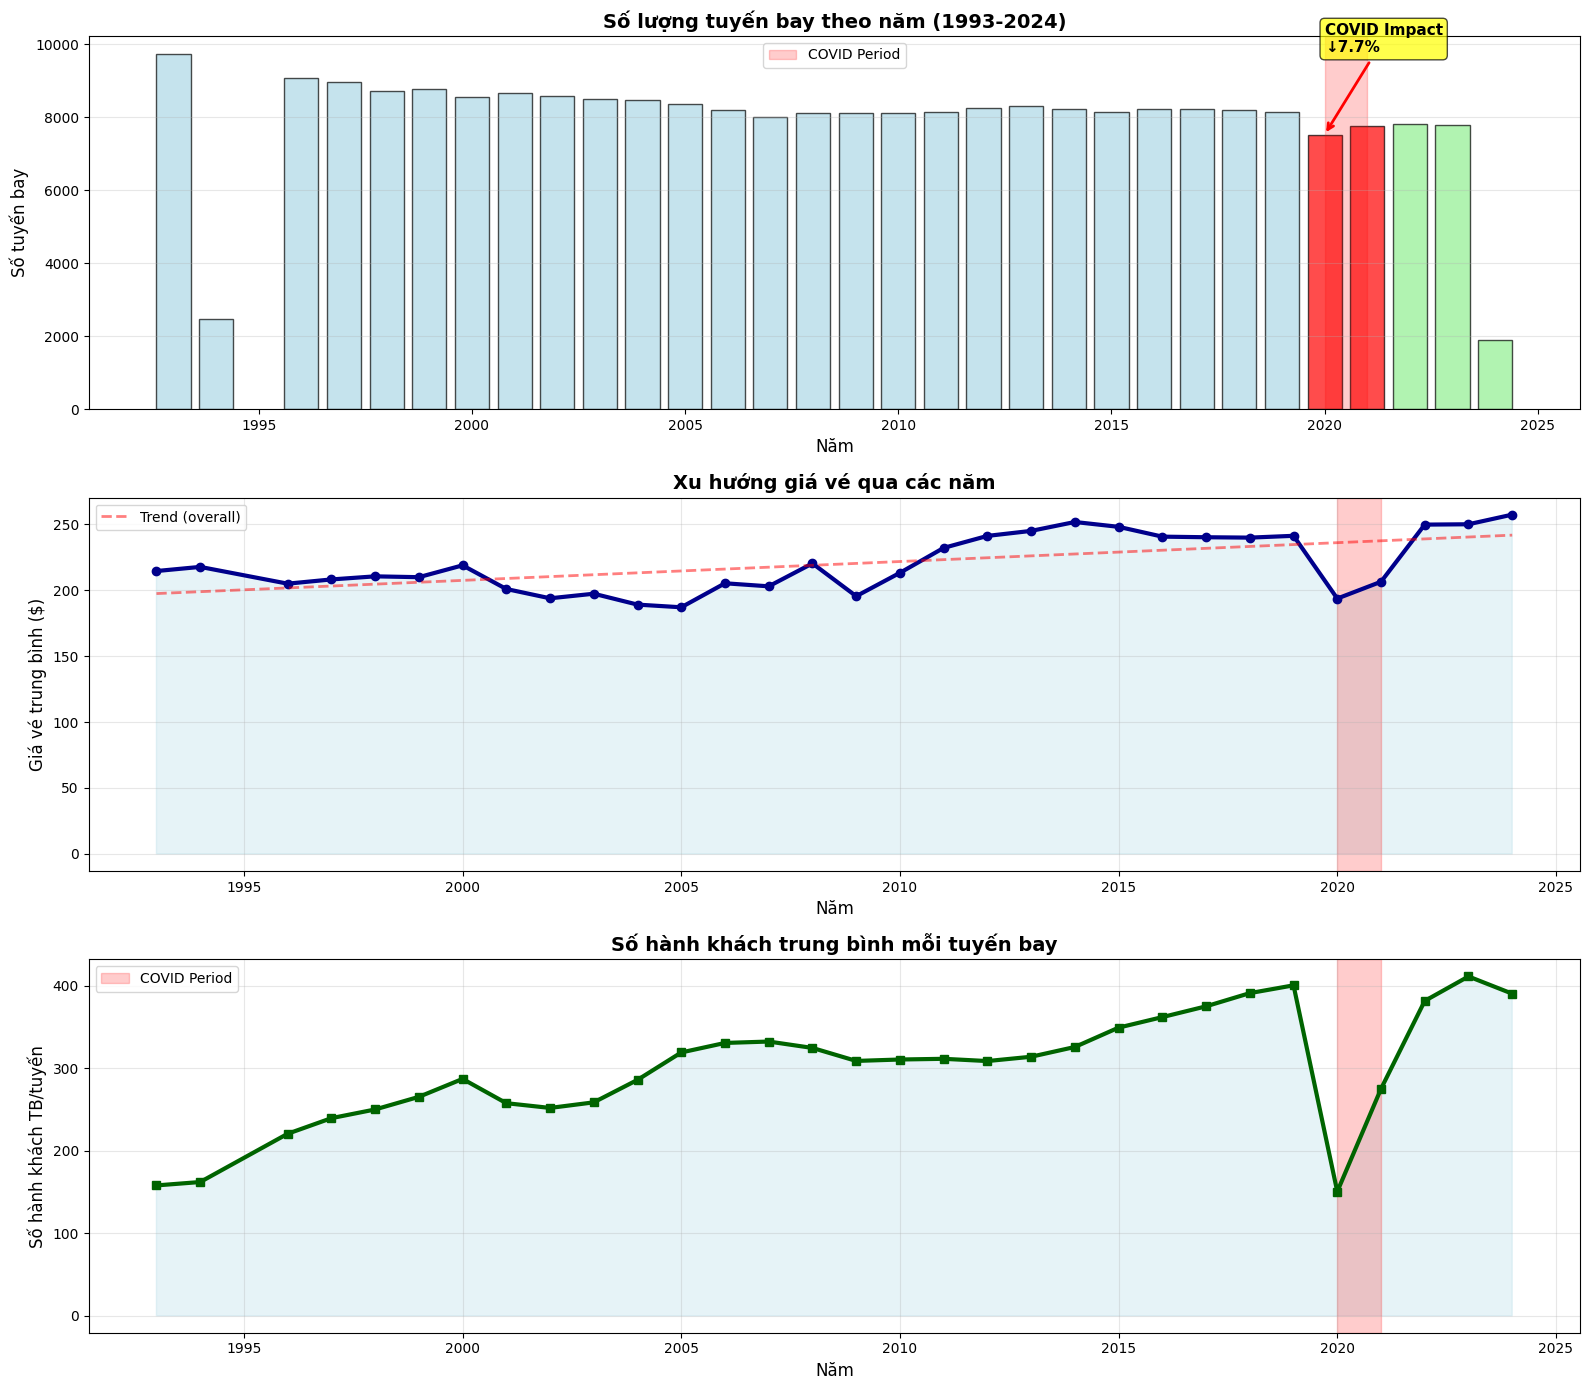

In [ ]:
# ============================================================
# CELL 9B: TR·ª∞C QUAN H√ìA T√ÅC ƒê·ªòNG COVID-19
# ============================================================
# M·ª•c ƒë√≠ch: V·∫Ω timeline ƒë·ªÉ th·∫•y r√µ s·ª± thay ƒë·ªïi

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import when, col, count, avg, sum # This import is likely not needed here as df_with_period is already created

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Colors cho periods
colors = yearly_stats['period'].map({
    'Pre-COVID': 'lightblue',
    'COVID': 'red',
    'Post-COVID': 'lightgreen'
})

# 1. S·ªê TUY·∫æN BAY THEO NƒÇM
axes[0].bar(yearly_stats['Year'], yearly_stats['num_routes'],
            color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('NƒÉm', fontsize=12)
axes[0].set_ylabel('S·ªë tuy·∫øn bay', fontsize=12)
axes[0].set_title('S·ªë l∆∞·ª£ng tuy·∫øn bay theo nƒÉm (1993-2024)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Highlight COVID period
axes[0].axvspan(2020, 2021, alpha=0.2, color='red', label='COVID Period')

# Th√™m annotation
covid_routes = yearly_stats[yearly_stats['Year'] == 2020]['num_routes'].values[0]
pre_covid_avg = yearly_stats[yearly_stats['Year'] == 2019]['num_routes'].values[0]
drop_pct = ((pre_covid_avg - covid_routes) / pre_covid_avg) * 100

axes[0].annotate(f'COVID Impact\n‚Üì{drop_pct:.1f}%',
                 xy=(2020, covid_routes),
                 xytext=(2020, covid_routes * 1.3),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
axes[0].legend()

# 2. GI√Å V√â TRUNG B√åNH THEO NƒÇM
axes[1].plot(yearly_stats['Year'], yearly_stats['avg_fare'],
             linewidth=3, marker='o', markersize=6, color='darkblue')

# Fill areas
axes[1].fill_between(yearly_stats['Year'], yearly_stats['avg_fare'],
                      alpha=0.3, color=colors)
axes[1].set_xlabel('NƒÉm', fontsize=12)
axes[1].set_ylabel('Gi√° v√© trung b√¨nh ($)', fontsize=12)
axes[1].set_title('Xu h∆∞·ªõng gi√° v√© qua c√°c nƒÉm', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvspan(2020, 2021, alpha=0.2, color='red')

# Th√™m trend line
z = np.polyfit(yearly_stats['Year'], yearly_stats['avg_fare'], 1)
p = np.poly1d(z)
axes[1].plot(yearly_stats['Year'], p(yearly_stats['Year']),
             "r--", linewidth=2, alpha=0.5, label='Trend (overall)')
axes[1].legend()

# 3. S·ªê H√ÄNH KH√ÅCH TRUNG B√åNH
axes[2].plot(yearly_stats['Year'], yearly_stats['avg_passengers'],
             linewidth=3, marker='s', markersize=6, color='darkgreen')
axes[2].fill_between(yearly_stats['Year'], yearly_stats['avg_passengers'],
                      alpha=0.3, color=colors)
axes[2].set_xlabel('NƒÉm', fontsize=12)
axes[2].set_ylabel('S·ªë h√†nh kh√°ch TB/tuy·∫øn', fontsize=12)
axes[2].set_title('S·ªë h√†nh kh√°ch trung b√¨nh m·ªói tuy·∫øn bay', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvspan(2020, 2021, alpha=0.2, color='red', label='COVID Period')
axes[2].legend()

plt.tight_layout()
plt.savefig('../image/covid_impact_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 X·ª≠ l√Ω c√°c gi√° tr·ªã ƒë·ªÉ t·∫°p t√≠n hi·ªáu b·∫•t th∆∞·ªùng

In [ ]:
# ============================================================
# CELL 11A: X·ª¨ L√ù D·ªÆ LI·ªÜU ƒê·∫¶U V√ÄO - CRISIS DETECTION
# ============================================================
# M·ª•c ƒë√≠ch: Aggregate data theo quarter v√† t·∫°o features

print("=" * 70)
print("X·ª¨ L√ù D·ªÆ LI·ªÜU ƒê·∫¶U V√ÄO CHO CRISIS DETECTION")
print("=" * 70)

from pyspark.sql.functions import *
from pyspark.sql import Window

# B∆∞·ªõc 1: Aggregate data theo Year-Quarter
print("\n1. AGGREGATE DATA THEO YEAR-QUARTER...")

df_quarterly = df.groupBy('Year', 'quarter').agg(
    # Volume metrics
    count('*').alias('num_routes'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers_per_route'),

    # Price metrics
    avg('fare').alias('avg_fare'),
    stddev('fare').alias('fare_std'),
    min('fare').alias('fare_min'),
    max('fare').alias('fare_max'),

    # Distance metrics
    avg('nsmiles').alias('avg_distance'),
    stddev('nsmiles').alias('distance_std'),

    # Competition metrics
    countDistinct('carrier_lg').alias('num_carriers'),
    avg('large_ms').alias('avg_market_share_large'),
    avg('lf_ms').alias('avg_market_share_lowcost')
).orderBy('Year', 'quarter')

# T·∫°o time_period identifier
df_quarterly = df_quarterly.withColumn('time_period',
    concat(col('Year').cast('string'), lit('-Q'), col('quarter').cast('string'))
)

print(f"  ‚úì Aggregated to {df_quarterly.count()} quarters")

# Hi·ªÉn th·ªã sample
print("\n  Sample data:")
df_quarterly.select('time_period', 'num_routes', 'total_passengers', 'avg_fare').show(10)

# B∆∞·ªõc 2: T·∫°o labels (COVID = crisis)
print("\n2. T·∫†O LABELS (COVID = CRISIS)...")

df_quarterly = df_quarterly.withColumn('is_crisis',
    when((col('Year') >= 2020) & (col('Year') <= 2021), 1.0)
    .otherwise(0.0)
)

# Ki·ªÉm tra ph√¢n b·ªë labels
label_distribution = df_quarterly.groupBy('is_crisis').count()
print("\n  Ph√¢n b·ªë labels:")
label_distribution.show()

# B∆∞·ªõc 3: Feature Engineering - Rate of Change
print("\n3. FEATURE ENGINEERING - RATE OF CHANGE...")

# Window specs
window_qoq = Window.orderBy('Year', 'quarter')
window_yoy = Window.orderBy('Year', 'quarter').rowsBetween(-4, -4)

# QoQ (Quarter-over-Quarter) changes
change_cols = ['num_routes', 'total_passengers', 'avg_fare', 'avg_distance']

for col_name in change_cols:
    # L·∫•y gi√° tr·ªã quarter tr∆∞·ªõc
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_q',
        lag(col(col_name), 1).over(window_qoq)
    )

    # T√≠nh % change
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_qoq',
        when(col(f'{col_name}_prev_q').isNotNull() & (col(f'{col_name}_prev_q') != 0),
             (col(col_name) - col(f'{col_name}_prev_q')) / col(f'{col_name}_prev_q'))
        .otherwise(0.0)
    )

    # Drop temp column
    df_quarterly = df_quarterly.drop(f'{col_name}_prev_q')

print("  ‚úì QoQ changes calculated")

# YoY (Year-over-Year) changes
yoy_cols = ['num_routes', 'total_passengers', 'avg_fare']

for col_name in yoy_cols:
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_year',
        lag(col(col_name), 4).over(window_qoq)
    )

    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_yoy',
        when(col(f'{col_name}_prev_year').isNotNull() & (col(f'{col_name}_prev_year') != 0),
             (col(col_name) - col(f'{col_name}_prev_year')) / col(f'{col_name}_prev_year'))
        .otherwise(0.0)
    )

    df_quarterly = df_quarterly.drop(f'{col_name}_prev_year')

print("  ‚úì YoY changes calculated")

# B∆∞·ªõc 4: Derived features
print("\n4. CREATING DERIVED FEATURES...")

# Volatility metrics
df_quarterly = df_quarterly.withColumn('fare_volatility',
    when(col('avg_fare') != 0, col('fare_std') / col('avg_fare')).otherwise(0.0)
)

df_quarterly = df_quarterly.withColumn('distance_volatility',
    when(col('avg_distance') != 0, col('distance_std') / col('avg_distance')).otherwise(0.0)
)

# Range metrics
df_quarterly = df_quarterly.withColumn('fare_range',
    col('fare_max') - col('fare_min')
)

# Passenger efficiency
df_quarterly = df_quarterly.withColumn('passenger_efficiency',
    when(col('num_routes') != 0, col('total_passengers') / col('num_routes')).otherwise(0.0)
)

print("  ‚úì Derived features created")

# B∆∞·ªõc 5: Handle missing values
print("\n5. HANDLING MISSING VALUES...")

# Fill NaN v·ªõi 0 (t·ª´ lag functions cho first rows)
df_quarterly = df_quarterly.fillna(0.0)

missing_check = df_quarterly.select([count(when(col(c).isNull(), c)).alias(c)
                                      for c in df_quarterly.columns])
print("\n  Missing values check:")
missing_check.show()

# B∆∞·ªõc 6: Select final features
print("\n6. SELECTING FEATURES FOR MODEL...")

feature_cols_final = [
    # Core volume metrics (3)
    'num_routes',
    'total_passengers',
    'avg_passengers_per_route',

    # Core price metrics (2)
    'avg_fare',
    'avg_distance',

    # Volatility metrics (2)
    'fare_volatility',
    'fare_range',

    # QoQ changes - IMPORTANT! (4)
    'num_routes_change_qoq',
    'total_passengers_change_qoq',
    'avg_fare_change_qoq',
    'avg_distance_change_qoq',

    # YoY changes (3)
    'num_routes_change_yoy',
    'total_passengers_change_yoy',
    'avg_fare_change_yoy',

    # Competition (2)
    'num_carriers',
    'avg_market_share_large',

    # Seasonal (1)
    'quarter',
]

print(f"\n  T·ªïng s·ªë features: {len(feature_cols_final)}")
print(f"\n  Danh s√°ch features:")
for i, feat in enumerate(feature_cols_final, 1):
    print(f"    {i:2}. {feat}")

# Hi·ªÉn th·ªã final dataset
print("\n7. FINAL DATASET:")
df_quarterly.select(['time_period', 'Year', 'quarter', 'is_crisis'] +
                    feature_cols_final[:5]).show(15)

print(f"\n‚úì Data preparation completed!")
print(f"  Total quarters: {df_quarterly.count()}")
print(f"  Total features: {len(feature_cols_final)}")
print(f"  Target: is_crisis (0 = Normal, 1 = COVID)")

X·ª¨ L√ù D·ªÆ LI·ªÜU ƒê·∫¶U V√ÄO CHO CRISIS DETECTION

1. AGGREGATE DATA THEO YEAR-QUARTER...
  ‚úì Aggregated to 118 quarters

  Sample data:
+-----------+----------+----------------+------------------+
|time_period|num_routes|total_passengers|          avg_fare|
+-----------+----------+----------------+------------------+
|    1993-Q1|      2395|          345741|236.60088935281794|
|    1993-Q2|      2459|          403857|209.41590483936557|
|    1993-Q3|      2448|          393045| 198.8709232026143|
|    1993-Q4|      2437|          395495|213.50024620434954|
|    1994-Q1|      2454|          397667| 217.6119437652813|
|    1996-Q1|      2270|          455842|210.39099118942724|
|    1996-Q2|      2317|          528950| 202.4628614587828|
|    1996-Q3|      2266|          513137|201.06954545454542|
|    1996-Q4|      2228|          504663|205.73692998204706|
|    1997-Q1|      2243|          498839|211.33452073116342|
+-----------+----------+----------------+------------------+
onl

## 2.3 C√¥ng vi·ªác ti·∫øp theo

Hu·∫•n luy·ªán m√¥ h√¨nh ƒë·ªÉ d·ª± ƒëo√°n b·∫•t th∆∞·ªùng, c·∫£nh b√°o th·∫£m h·ªça h√†ng kh√¥ng

# 3 Airline market share prediction model

In [ ]:
feature_cols = numeric_features + [col+"_indexed" for col in categorical_features]
feature_cols.append('is_largest_cheapest')

In [ ]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

In [ ]:
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

In [ ]:
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

print(f"\n=== CHIA D·ªÆ LI·ªÜU ===")
print(f"S·ªë d√≤ng train: {train_data.count()}")
print(f"S·ªë d√≤ng test: {test_data.count()}")


=== CHIA D·ªÆ LI·ªÜU ===
S·ªë d√≤ng train: 190123
S·ªë d√≤ng test: 47862


In [ ]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="large_ms",
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0.5
)

In [ ]:
pipeline_lr = Pipeline(stages=indexers + [assembler, scaler, lr])
model_lr = pipeline_lr.fit(train_data)
predictions_lr = model_lr.transform(test_data)

In [ ]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="large_ms",
    numTrees=100,
    maxDepth=10,
    seed=42
)

In [ ]:
pipeline_rf = Pipeline(stages=indexers + [assembler, scaler, rf])
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)

In [ ]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="large_ms",
    maxIter=100,
    maxDepth=5,
    seed=42
)

In [ ]:

pipeline_gbt = Pipeline(stages=indexers + [assembler, scaler, gbt])
model_gbt = pipeline_gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)

In [ ]:
evaluator_rmse = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="mae"
)

In [ ]:
print("\nLinear Regression:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_lr):.4f}")
print(f"  R2: {evaluator_r2.evaluate(predictions_lr):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_lr):.4f}")

print("\nRandom Forest:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_rf):.4f}")
print(f"  R2: {evaluator_r2.evaluate(predictions_rf):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_rf):.4f}")

print("\nGradient Boosted Trees:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_gbt):.4f}")
print(f"  R2: {evaluator_r2.evaluate(predictions_gbt):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_gbt):.4f}")


Linear Regression:
  RMSE: 0.1943
  R2: 0.2376
  MAE: 0.1699

Random Forest:
  RMSE: 0.0840
  R2: 0.8573
  MAE: 0.0554

Gradient Boosted Trees:
  RMSE: 0.0765
  R2: 0.8818
  MAE: 0.0481


In [ ]:
rf_model = model_rf.stages[-1]
feature_importance = rf_model.featureImportances.toArray()

feature_names = feature_cols
importance_df = spark.createDataFrame(
    [(name, float(imp)) for name, imp in zip(feature_names, feature_importance)],
    ['feature', 'importance']
).orderBy(col('importance').desc())

importance_df.show(20)

+-------------------+--------------------+
|            feature|          importance|
+-------------------+--------------------+
|              lf_ms|  0.6691844630064311|
|    fare_difference| 0.13569947965126553|
|            nsmiles| 0.06421050930453445|
|      fare_per_mile| 0.03515753599119153|
|is_largest_cheapest|0.034181782479342816|
|            revenue| 0.01794006182416434|
|         passengers|0.016684549979397834|
| carrier_lg_indexed|0.010819914920363834|
|               Year|0.006604698071603944|
|carrier_low_indexed|0.004857337121019847|
|               fare|0.002854490995978...|
|           fare_low|0.001720933992446...|
|            quarter|8.424266225933034E-5|
+-------------------+--------------------+



In [ ]:
predictions_rf.select(
    'large_ms', 'prediction',
    'passengers', 'fare', 'nsmiles', 'carrier_lg'
).show(10)

+--------+------------------+----------+------+-------+----------+
|large_ms|        prediction|passengers|  fare|nsmiles|carrier_lg|
+--------+------------------+----------+------+-------+----------+
|    0.85|0.8534900135796164|       133|275.63|    654|        UA|
|    0.37|0.5309484391287608|         4|267.08|   1974|        US|
|    0.26|0.4312600977159158|        68|258.75|   1670|        DL|
|    0.83|0.8495292097959413|        57|139.36|   1123|        WN|
|    0.66| 0.646960262991727|         4|223.75|   1861|        NW|
|     0.8|0.7667079022924445|         7| 326.4|   1861|        DL|
|    0.94|0.9354262355257376|       888| 86.67|    677|        WN|
|    0.53|0.4827445549495522|        23|289.51|   1504|        UA|
|     0.5|0.4973493884381909|        26|222.54|    963|        UA|
|    0.44|0.5055744906018458|        71|204.62|    963|        UA|
+--------+------------------+----------+------+-------+----------+
only showing top 10 rows



In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="large_ms", maxIter=100)

In [ ]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .addGrid(lr.maxIter, [50, 100, 200]) \
    .build()

In [ ]:
# Cross-validator
cv_lr = CrossValidator(
    estimator=Pipeline(stages=indexers + [assembler, scaler, lr]),
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_rmse,
    numFolds=3,  # 3-fold cross-validation
    parallelism=2,
    seed=42
)

In [ ]:
cv_model_lr = cv_lr.fit(train_data)

In [ ]:
best_lr_model = cv_model_lr.bestModel.stages[-1]
print("Best parameters cho Linear Regression:")
print(f"  regParam: {best_lr_model.getRegParam()}")
print(f"  elasticNetParam: {best_lr_model.getElasticNetParam()}")
print(f"  maxIter: {best_lr_model.getMaxIter()}\n")

Best parameters cho Linear Regression:
  regParam: 0.0
  elasticNetParam: 0.0
  maxIter: 50



In [ ]:
predictions_lr = cv_model_lr.transform(test_data)
print("K·∫øt qu·∫£ tr√™n Test Set:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_lr):.4f}")
print(f"  R¬≤: {evaluator_r2.evaluate(predictions_lr):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_lr):.4f}\n")

K·∫øt qu·∫£ tr√™n Test Set:
  RMSE: 0.1721
  R¬≤: 0.4013
  MAE: 0.1381



In [ ]:
# Cross-validation scores
cv_scores_lr = cv_model_lr.avgMetrics
print("Cross-Validation Scores (RMSE):")
for idx, score in enumerate(cv_scores_lr[:5]):  # Top 5
    print(f"  Config {idx+1}: {score:.4f}")


Cross-Validation Scores (RMSE):
  Config 1: 0.1725
  Config 2: 0.1725
  Config 3: 0.1725
  Config 4: 0.1725
  Config 5: 0.1725


In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="large_ms", seed=42)
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

In [ ]:
# TrainValidationSplit (nhanh h∆°n CrossValidator cho RF)
tvs_rf = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, rf]),
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_rmse,
    trainRatio=0.8,  # 80% train, 20% validation
    parallelism=2,
    seed=42
)

In [ ]:
tvs_model_rf = tvs_rf.fit(train_data)

In [ ]:
# Best parameters
best_rf_model = tvs_model_rf.bestModel.stages[-1]
print("Best parameters cho Random Forest:")
print(f"  numTrees: {best_rf_model.getNumTrees}")
print(f"  maxDepth: {best_rf_model.getMaxDepth()}")
print(f"  minInstancesPerNode: {best_rf_model.getMinInstancesPerNode()}")
print(f"  maxBins: {best_rf_model.getMaxBins()}\n")

Best parameters cho Random Forest:
  numTrees: 150
  maxDepth: 20
  minInstancesPerNode: 1
  maxBins: 64



In [ ]:
# ƒê√°nh gi√° tr√™n test set
predictions_rf = tvs_model_rf.transform(test_data)
print("K·∫øt qu·∫£ tr√™n Test Set:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_rf):.4f}")
print(f"  R¬≤: {evaluator_r2.evaluate(predictions_rf):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_rf):.4f}\n")

K·∫øt qu·∫£ tr√™n Test Set:
  RMSE: 0.0670
  R¬≤: 0.9092
  MAE: 0.0394



In [ ]:
# GBT v·ªõi hyperparameter tuning
gbt = GBTRegressor(featuresCol="features", labelCol="large_ms", seed=42)

# Param grid cho GBT
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [50, 100, 150]) \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.stepSize, [0.01, 0.1, 0.2]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .build()

In [ ]:
# TrainValidationSplit cho GBT
tvs_gbt = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, gbt]),
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator_rmse,
    trainRatio=0.8,
    parallelism=2,
    seed=42
)

In [ ]:
tvs_model_gbt = tvs_gbt.fit(train_data)

In [ ]:
# Best parameters
best_gbt_model = tvs_model_gbt.bestModel.stages[-1]
print("Best parameters cho GBT:")
print(f"  maxIter: {best_gbt_model.getMaxIter()}")
print(f"  maxDepth: {best_gbt_model.getMaxDepth()}")
print(f"  stepSize: {best_gbt_model.getStepSize()}")
print(f"  subsamplingRate: {best_gbt_model.getSubsamplingRate()}\n")

Best parameters cho GBT:
  maxIter: 150
  maxDepth: 7
  stepSize: 0.1
  subsamplingRate: 1.0



In [ ]:
# ƒê√°nh gi√° tr√™n test set
predictions_gbt = tvs_model_gbt.transform(test_data)
print("K·∫øt qu·∫£ tr√™n Test Set:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_gbt):.4f}")
print(f"  R¬≤: {evaluator_r2.evaluate(predictions_gbt):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_gbt):.4f}\n")

K·∫øt qu·∫£ tr√™n Test Set:
  RMSE: 0.0695
  R¬≤: 0.9024
  MAE: 0.0429



# 4 Building a potential classification model

## Prepare for model training

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, when, round

# STEP 1: CALCULATE POTENTIAL SCORE (POTENTIAL SCORE)
print("B∆Ø·ªöC 1: T√çNH TO√ÅN ƒêI·ªÇM S·ªê TI·ªÄM NƒÇNG")
print("="*50)

# Make a copy of the data for processing
df_potential = df_clean

# Normalize metrics to [0,1] scale
metrics = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']

# Calculate min and max for normalization
min_max_stats = {}
for metric in metrics:
    if metric in df_potential.columns:
        stats = df_potential.select(
            F.min(col(metric)).alias("min_val"),
            F.max(col(metric)).alias("max_val")
        ).collect()[0]
        min_max_stats[metric] = {
            'min': stats['min_val'],
            'max': stats['max_val']
        }

# Normalization each metrics
for metric in metrics:
    if metric in df_potential.columns and metric in min_max_stats:
        min_val = min_max_stats[metric]['min']
        max_val = min_max_stats[metric]['max']
        if max_val != min_val:
            df_potential = df_potential.withColumn(
                f'{metric}_normalized',
                (col(metric) - lit(min_val)) / (lit(max_val) - lit(min_val))
            )
        else:
            df_potential = df_potential.withColumn(f'{metric}_normalized', lit(0.0))

# Calculate potential score based on weight
weights = {
    'passengers_normalized': 0.25,
    'fare_normalized': 0.2,
    'nsmiles_normalized': 0.25,
    'large_ms_normalized': 0.15,
    'lf_ms_normalized': 0.15
}

potential_score_expr = lit(0.0)
for metric, weight in weights.items():
    if metric in df_potential.columns:
        potential_score_expr = potential_score_expr + (col(metric) * weight)

df_potential = df_potential.withColumn('potential_score', potential_score_expr)

# Classify based on potential score
df_potential = df_potential.withColumn(
    'potential_level',
    when(col('potential_score') > 0.4, 'Cao')
    .when(col('potential_score') >= 0.3, 'Trung b√¨nh')
    .otherwise('Th·∫•p')
)

# Distribution statistics
print("\nPh√¢n b·ªë ti·ªÅm nƒÉng tuy·∫øn bay:")
potential_dist = df_potential.groupBy('potential_level').count().orderBy('potential_level')
potential_dist.show()

# Calculate percentage
total_count = df_potential.count()
potential_percentages = df_potential.groupBy('potential_level').count() \
    .withColumn('percentage', round(col('count') / lit(total_count) * 100, 3)) \
    .orderBy('potential_level')

print("\nT·ª∑ l·ªá ph·∫ßn trƒÉm:")
potential_percentages.show()


B∆Ø·ªöC 1: T√çNH TO√ÅN ƒêI·ªÇM S·ªê TI·ªÄM NƒÇNG

Ph√¢n b·ªë ti·ªÅm nƒÉng tuy·∫øn bay:
+---------------+------+
|potential_level| count|
+---------------+------+
|            Cao| 27047|
|           Th·∫•p|120694|
|     Trung b√¨nh| 90244|
+---------------+------+


T·ª∑ l·ªá ph·∫ßn trƒÉm:
+---------------+------+----------+
|potential_level| count|percentage|
+---------------+------+----------+
|            Cao| 27047|    11.365|
|           Th·∫•p|120694|    50.715|
|     Trung b√¨nh| 90244|     37.92|
+---------------+------+----------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import first, last, col, lit, when

# STEP 2: ADDITIONAL GROWTH TREND ANALYSISA
print("\nB∆Ø·ªöC 2: PH√ÇN T√çCH XU H∆Ø·ªöNG TƒÇNG TR∆Ø·ªûNG")
print("=" * 50)

# Create window partitioned by route (city1, city2) ordered by Year
window_spec = Window.partitionBy('city1', 'city2').orderBy('Year') \
                   .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Calculate first and last values for each route
df_with_growth = df_potential.withColumn(
    'first_passengers', first('passengers').over(window_spec)
).withColumn(
    'last_passengers', last('passengers').over(window_spec)
).withColumn(
    'first_fare', first('fare').over(window_spec)
).withColumn(
    'last_fare', last('fare').over(window_spec)
)

# Calculate growth rates
df_with_growth = df_with_growth.withColumn(
    'passenger_growth',
    when(col('first_passengers') > 0,
         (col('last_passengers') - col('first_passengers')) / col('first_passengers'))
    .otherwise(0)
).withColumn(
    'fare_growth',
    when(col('first_fare') > 0,
         (col('last_fare') - col('first_fare')) / col('first_fare'))
    .otherwise(0)
)

# Calculate growth trends score (70% passengers, 30% fare)
df_with_growth = df_with_growth.withColumn(
    'growth_trend',
    0.7 * col('passenger_growth') + 0.3 * col('fare_growth')
)

# Normalize growth trends to [0,1]
growth_stats = df_with_growth.select(
    F.min('growth_trend').alias('min_growth'),
    F.max('growth_trend').alias('max_growth')
).collect()[0]

min_growth = growth_stats['min_growth']
max_growth = growth_stats['max_growth']

if max_growth != min_growth:
    df_with_growth = df_with_growth.withColumn(
        'growth_trend_normalized',
        (col('growth_trend') - lit(min_growth)) / (lit(max_growth) - lit(min_growth))
    )
else:
    df_with_growth = df_with_growth.withColumn('growth_trend_normalized', lit(0.0))

# Update potential score with growth trend (10% weight)
df_potential = df_with_growth.withColumn(
    'potential_score_enhanced',
    col('potential_score') * 0.9 + col('growth_trend_normalized') * 0.1
)

# Reclassify based on enhanced potential score
df_potential = df_potential.withColumn(
    'potential_level_enhanced',
    when(col('potential_score_enhanced') > 0.4, 'Cao')
    .when(col('potential_score_enhanced') >= 0.3, 'Trung b√¨nh')
    .otherwise('Th·∫•p')
)

# Display distribution results
print("\nPh√¢n b·ªë ti·ªÅm nƒÉng sau khi c·∫£i ti·∫øn:")
enhanced_dist = df_potential.groupBy('potential_level_enhanced').count().orderBy('potential_level_enhanced')
enhanced_dist.show()



B∆Ø·ªöC 2: PH√ÇN T√çCH XU H∆Ø·ªöNG TƒÇNG TR∆Ø·ªûNG

Ph√¢n b·ªë ti·ªÅm nƒÉng sau khi c·∫£i ti·∫øn:
+------------------------+------+
|potential_level_enhanced| count|
+------------------------+------+
|                     Cao| 12437|
|                    Th·∫•p|151411|
|              Trung b√¨nh| 74137|
+------------------------+------+



In [ ]:
# STEP 3: TRAIN MACHINE LEARNING MODEL

print("\nB∆Ø·ªöC 3: HU·∫§N LUY·ªÜN M√î H√åNH MACHINE LEARNING")
print("="*50)

# # Prepare features
features_ml = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'growth_trend']

# Create feature vector
assembler = VectorAssembler(
    inputCols=features_ml,
    outputCol="features"
)

# String indexer for target variable
label_indexer = StringIndexer(
    inputCol="potential_level_enhanced",
    outputCol="label"
)
# Create pipeline for feature preparation
feature_pipeline = Pipeline(stages=[assembler, label_indexer])
df_ml = feature_pipeline.fit(df_potential).transform(df_potential)

# Split data (80% train , 20% test)
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

print(f"K√≠ch th∆∞·ªõc d·ªØ li·ªáu:")
print(f"  - Train: {train_data.count()} m·∫´u")
print(f"  - Test: {test_data.count()} m·∫´u")
print(f"  - S·ªë ƒë·∫∑c tr∆∞ng: {len(features_ml)}")


B∆Ø·ªöC 3: HU·∫§N LUY·ªÜN M√î H√åNH MACHINE LEARNING
K√≠ch th∆∞·ªõc d·ªØ li·ªáu:
  - Train: 190573 m·∫´u
  - Test: 47412 m·∫´u
  - S·ªë ƒë·∫∑c tr∆∞ng: 8


In [ ]:
# Function to evaluate model
def evaluate_model(predictions):
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_pre = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    accuracy = evaluator_acc.evaluate(predictions)
    precision = evaluator_pre.evaluate(predictions)
    recall = evaluator_rec.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"  - Accuracy : {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall   : {recall:.4f}")
    print(f"  - F1-Score : {f1:.4f}")

    return accuracy

## `Random Forest`

###  `Random Forest` Training

In [ ]:
# RANDOM FOREST
from pyspark.ml.classification import RandomForestClassifier

print("\n HU·∫§N LUY·ªÜN M√î H√åNH: Random Forest")
print("-" * 60)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=20,
    maxDepth=5,
    seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("K·∫øt qu·∫£ ƒë√°nh gi√° Random Forest:")
rf_accuracy = evaluate_model(rf_predictions)


 HU·∫§N LUY·ªÜN M√î H√åNH: Random Forest
------------------------------------------------------------
K·∫øt qu·∫£ ƒë√°nh gi√° Random Forest:
  - Accuracy : 0.8924
  - Precision: 0.8946
  - Recall   : 0.8924
  - F1-Score : 0.8925


###  `Random Forest` ‚Äì Find optimal hyperparameters - numTrees, maxDepth, maxBins

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

paramGrid_rf = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [35, 50, 75, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.maxBins, [32, 64])
    .build()
)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_rf = cv_rf.fit(train_data)
best_rf_model = cvModel_rf.bestModel
rf_predictions = best_rf_model.transform(test_data)

print(" Best Random Forest parameters:")
print(f"  numTrees = {best_rf_model.getNumTrees}")
print(f"  maxDepth = {best_rf_model.getOrDefault('maxDepth')}")
print(f"  maxBins  = {best_rf_model.getOrDefault('maxBins')}")

rf_accuracy = evaluator.evaluate(rf_predictions)
print(f" Accuracy (Random Forest): {rf_accuracy:.4f}")


 Best Random Forest parameters:
  numTrees = 100
  maxDepth = 15
  maxBins  = 64
 Accuracy (Random Forest): 0.9794


## `Logistic Regression`

### `Logistic Regression` Training



In [ ]:
# LOGISTIC REGRESSION
from pyspark.ml.classification import LogisticRegression

print("\n HU·∫§N LUY·ªÜN M√î H√åNH: Logistic Regression")
print("-" * 60)

# Ch·ªâ c√≥ L2 regularization
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("K·∫øt qu·∫£ ƒë√°nh gi√° Logistic Regression:")
lr_accuracy = evaluate_model(lr_predictions)



 HU·∫§N LUY·ªÜN M√î H√åNH: Logistic Regression
------------------------------------------------------------
K·∫øt qu·∫£ ƒë√°nh gi√° Logistic Regression:
  - Accuracy : 0.9421
  - Precision: 0.9451
  - Recall   : 0.9421
  - F1-Score : 0.9365


### `Logistic Regression` ‚Äì Find optimal hyperparameters - regParam, elasticNetParam

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=1000)

paramGrid_lr = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.1, 0.3, 0.5, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])  # 0=L2, 1=L1
    .build()
)

cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_lr = cv_lr.fit(train_data)
best_lr_model = cvModel_lr.bestModel
lr_predictions = best_lr_model.transform(test_data)

print(" Best Logistic Regression parameters:")
print(f"  regParam = {best_lr_model.getRegParam()}")
print(f"  elasticNetParam = {best_lr_model.getElasticNetParam()}")

lr_accuracy = evaluator.evaluate(lr_predictions)
print(f" Accuracy (Logistic Regression): {lr_accuracy:.4f}")


 Best Logistic Regression parameters:
  regParam = 0.001
  elasticNetParam = 1.0
 Accuracy (Logistic Regression): 0.9950


## Find the best model

In [ ]:
import builtins  # d√πng max g·ªëc c·ªßa Python

models_info = [
    {
        "name": "Random Forest",
        "accuracy": rf_accuracy,
        "params": {
            "numTrees": best_rf_model.getNumTrees,
            "maxDepth": best_rf_model.getOrDefault("maxDepth"),
            "maxBins": best_rf_model.getOrDefault("maxBins")
        }
    },
    {
        "name": "Logistic Regression",
        "accuracy": lr_accuracy,
        "params": {
            "regParam": best_lr_model.getRegParam(),
            "elasticNetParam": best_lr_model.getElasticNetParam()
        }
    }
]

# D√πng builtins.max
best_model = builtins.max(models_info, key=lambda m: m["accuracy"])

print("\n So s√°nh m√¥ h√¨nh:")
for m in models_info:
    marker = "" if m["name"] == best_model["name"] else "  "
    print(f"{marker} {m['name']}: Accuracy = {m['accuracy']:.4f}")
    for k, v in m["params"].items():
        print(f"     {k}: {v}")
    print("-" * 50)

print(f"\n M√¥ h√¨nh t·ªët nh·∫•t: {best_model['name']} (ƒê·ªô ch√≠nh x√°c = {best_model['accuracy']:.4f})")
print("  Si√™u tham s·ªë t·ªëi ∆∞u:")
for k, v in best_model["params"].items():
    print(f"   {k}: {v}")



 So s√°nh m√¥ h√¨nh:
   Random Forest: Accuracy = 0.9794
     numTrees: 100
     maxDepth: 15
     maxBins: 64
--------------------------------------------------
 Logistic Regression: Accuracy = 0.9950
     regParam: 0.001
     elasticNetParam: 1.0
--------------------------------------------------

 M√¥ h√¨nh t·ªët nh·∫•t: Logistic Regression (ƒê·ªô ch√≠nh x√°c = 0.9950)
  Si√™u tham s·ªë t·ªëi ∆∞u:
   regParam: 0.001
   elasticNetParam: 1.0


## Test

In [ ]:
from pyspark.sql.functions import udf, col, rand
from pyspark.sql.types import StringType

# Map numeric labels to string labels (based on trained StringIndexer order)
label_mapping = {0.0: "Cao", 1.0: "Trung b√¨nh", 2.0: "Th·∫•p"}
map_label_udf = udf(lambda x: label_mapping.get(x, "Kh√¥ng r√µ"), StringType())

# Get 10 random samples from test set
sample_test = test_data.orderBy(rand()).limit(10)

# Determine the best model
if best_model["name"] == "Random Forest":
    best_model_object = best_rf_model
elif best_model["name"] == "Logistic Regression":
    best_model_object = best_lr_model
else:
    raise ValueError("Kh√¥ng x√°c ƒë·ªãnh ƒë∆∞·ª£c m√¥ h√¨nh t·ªët nh·∫•t!")

# Make predictions
sample_predictions = best_model_object.transform(sample_test)

# Add true and predicted labels in string format
sample_with_labels = (
    sample_predictions
    .withColumn("Label_th·∫≠t", map_label_udf(col("label")))
    .withColumn("D·ª±_ƒëo√°n", map_label_udf(col("prediction")))
)

# Display key columns
columns_to_show = [
    "city1", "city2", "passengers", "fare", "nsmiles",
    "large_ms", "lf_ms", "fare_lg", "fare_low",
    "Label_th·∫≠t", "D·ª±_ƒëo√°n"
]

print(f"\n D·ª± ƒëo√°n 10 m·∫´u ng·∫´u nhi√™n b·∫±ng m√¥ h√¨nh t·ªët nh·∫•t: {best_model['name']}")
sample_with_labels.select(columns_to_show).show(truncate=False)



 D·ª± ƒëo√°n 10 m·∫´u ng·∫´u nhi√™n b·∫±ng m√¥ h√¨nh t·ªët nh·∫•t: Logistic Regression
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+----------+
|city1                                |city2                                |passengers|fare  |nsmiles|large_ms|lf_ms |fare_lg|fare_low|Label_th·∫≠t|D·ª±_ƒëo√°n   |
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+----------+
|Chicago, IL                          |Tulsa, OK                            |219       |159.12|585    |0.68    |0.28  |158.78 |157.54  |Cao       |Cao       |
|Miami, FL (Metropolitan Area)        |Pittsburgh, PA                       |218       |168.14|1013   |0.77    |0.04  |171.81 |109.38  |Cao       |Cao       |
|Indianapolis, IN                     |New York City, NY (Metropolitan Area)|447       |240.15|700    |0.77    